# Finding the Cross Reactivity of Antibodies

Antibodies interact with their protein target in certain regions (or sequences) called epitopes. The antibody cross reactivity can be defined as: the ability of an antibody to interact with the same protein in different species. To predict the cross reactivity, the epitope sequence can be compared “aligned” against the sequences of the corresponding proteins in other species. The alignment results (sequence similarity and identity), can be used to indicate the likelihood of cross reactivity. Usually, the higher the sequence similarity, the more likely that antibody will bind.

## Problem 
Predict the cross reactivity of the given antibodies (<span style="color:DarkGoldenRod">Epitope_table.csv</span>) that are known to target the given proteins (<span style="color:DarkGoldenRod">Epitope_mapping.csv</span>) 

In [1]:
import os
import pandas as pd
from Bio import SeqIO
from Bio import pairwise2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Let's look at the antibodies file:

In [2]:
path = os.getcwd()+'/epitopes/'
anti_df = pd.read_csv(path+"Epitopes_table.csv", sep="\t")
anti_df.head(3)

,Vendor,SKU,epitope,specificity,Immunogen,start,stop
0,Abcam,AB108050,Synthetic peptide corresponding to a region wi...,N Terminus,KCSHVACGRYIEDHALKHFEETGHPLAMEV,40.0,69.0
1,Abcam,AB68554,Synthetic peptide corresponding to Mouse GABA ...,C Terminus,VTMILSSQQDAAFAFASLAIVFS,822.0,844.0
2,Abcam,AB135356,Synthetic peptide corresponding to N terminal ...,N Terminus,LRVMNSQEQD,225.0,274.0


In [3]:
anti_df.shape[0]

100

And the mapping file:

In [4]:
anti2prot_df = pd.read_csv(path+"Epitopes_mapping.csv", sep="\t")
anti2prot_df.head(3)

,Vendor,SKU,Preferred_Name
0,Abcam,AB102672,Q9H244
1,Abcam,AB102672,Q9CPV9
2,Abcam,AB102672,Q9EPX4


In [5]:
anti2prot_df.shape[0]

1433

In [6]:
anti2prot_df.loc[:,"Preferred_Name"].to_csv(path+"prot_ids.txt", sep=" ", index=False, header=False)

For instance, the first row shows the anitibody with SKU=AB102672 and Vendor=Abcam targets the protein with the name=Q9H244 

## Method

1- I get the list of protein target UniProt IDs from the mapping file (i.e., the Preferred_name column) and save them to a file (e.g., prot_ids.txt). In Uniprot | retrieve/mapping, I set from UniprotKB_ID to Gene name and upload prot_ids.txt, then I download the mapping file to <span style="color:DarkGoldenRod">prot2gene.csv</span>.

In [7]:
prot2gene_df = pd.read_csv(path+"prot2gene.csv", sep="\t")
prot2gene_df.head(3)

,From,To
0,Q9H244,P2RY12
1,Q9CPV9,P2ry12
2,Q9EPX4,P2ry12


Now, I make gene names consistant (i.e., convert all gene names to lower case)

In [8]:
prot2gene_df.To = prot2gene_df.To.apply(lambda x: x.lower())
prot2gene_df.head(3)

,From,To
0,Q9H244,p2ry12
1,Q9CPV9,p2ry12
2,Q9EPX4,p2ry12


2- I retrieve the gene names from <span style="color:DarkGoldenRod">prot2gene.csv</span> and save them into a file (e.g., gene_names.txt). In UniProt | retrieve/mapping, I set from Gene name to UniprotKB_ID in Any Organism, and upload gene_names.txt, then I download the result (FASTA format) for five popular organisms, separately:
- <span style="color:DarkGoldenRod">uniprot_human.fasta</span>
- <span style="color:DarkGoldenRod">uniprot_mouse.fasta</span>
- <span style="color:DarkGoldenRod">uniprot_rat.fasta</span>
- <span style="color:DarkGoldenRod">uniprot_zebraf.fasta</span>
- <span style="color:DarkGoldenRod">uniprot_bovine.fasta</span>

3- Now, I do the following steps to find antibodies cross creativity, then save them into the result file (i.e., <span style="color:DarkGoldenRod">CR_table.csv</span>):
    1. For each antibody in EpitopeTable:
        - Retrieve epitope sequence (Immunogen column) for the antibody
        - For each fasta sequence:
            - Extract its UniProt_ID and gene name
            - Check if a protein target of this antibody is related to the same gene name as the current fasta
              sequence. In this case, find the score of local alignment of epitope sequence and fasta sequence.
    2. Sort scores group by antibody
    3. Normalize scores (min-max method) group by antibody

In [9]:
# This function extract uniprot_id which is between the first two pipes in fasta.id
#
def findUniProtID (text):
    p1 = text.find('|')
    p2 = text[p1+1:].find('|')
    if p2==-1:
        return text[p1+1:]
    else:
        return text[p1+1:p1+p2+1]

# This function extract gene_name which is after 'GN=' in fasta.description
#
def findGeneName (text):
    p1 = text.find('GN=')
    p2 = text[p1+3:].find(' ')
    if p2==-1:
        return text[p1+3:]
    else:
        return text[p1+3:p1+p2+3]

# construct cr dataframe
# compare each epitope sequence with the same protein sequences from 5 organisms
#
organisms = ['Human', 'Mouse', 'Rat', 'Zebrafish', 'Bovine']
fasta_fnames = ['uniprot_human.fasta','uniprot_mouse.fasta','uniprot_rat.fasta','uniprot_zebraf.fasta','uniprot_bovine.fasta']
epitopes = anti_df.Immunogen
ei_list = range(len(epitopes))
oi_list = range(len(organisms))
cr_df = pd.DataFrame(columns=['Vendor', 'SKU', 'Preferred_Name', 'Name', 'Organism', 'Align_Score'])
cr_count=0
for oi in oi_list:
    for ei in ei_list:
        ev = epitopes[ei]
        if ev==ev: # True, if ev is not null

            # retrieve protein targets of the antibody related to this epitope
            e_prot_list = []
            e_prot_list = anti2prot_df[anti2prot_df.SKU==anti_df.SKU[ei]].Preferred_Name.tolist()

            fasta_sequences = SeqIO.parse(open(path+fasta_fnames[oi]),'fasta')
            for fasta in fasta_sequences:
                sequence = str(fasta.seq)
                uni_id = findUniProtID(fasta.id)
                gn = findGeneName(fasta.description)

                # retrieve proteins related to the gene name:gn
                g_prot_list = []
                g_prot_list = prot2gene_df[prot2gene_df.To==gn.lower()].From.tolist()

                # Check if a protein target of this antibody is the same as the current fasta protein in the fasta organism, i.e.,
                # Check if a protein target of this antibody is related to the same gene name as the current fasta sequence
                if list(set(e_prot_list) & set(g_prot_list)):

                    # Check if the current fasta protein is not in the antibody's target protein list
                    # (if it is, it means we already have that fasta protein in Epitopes_mapping.txt for the antibody,
                    # i.e., they are from the same organism, so we do not need alignment/prediction).
                    if not (uni_id in anti2prot_df[anti2prot_df.SKU == anti_df.SKU[ei]].Preferred_Name.tolist()):
                        score = pairwise2.align.localxx(ev, sequence,score_only=True)
                        cr_df.loc[cr_count] = [anti_df.Vendor[ei], anti_df.SKU[ei], uni_id, gn, organisms[oi], score]
                        cr_count = cr_count + 1

# sort scores groupby antibodies
#
cr_df.sort_values(['Vendor', 'SKU', 'Align_Score'], ascending=[True, True, False], inplace=True)

# normalize scores groupby antibodies
#
cr_df['Align_Score_norm'] = cr_df.groupby('SKU')['Align_Score'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
cr_df['Align_Score_norm'] = cr_df['Align_Score_norm'].round(2)

# save the result
#
cr_df.to_csv(path+"CR_table.csv", index=None)

In [10]:
cr_df.head()

,Vendor,SKU,Preferred_Name,Name,Organism,Align_Score,Align_Score_norm
43,Abcam,AB102672,A0A2H4P6E7,P2RY12,Human,100.0,1.00
213,Abcam,AB102672,Q546L4,P2ry12,Mouse,92.0,0.76
214,Abcam,AB102672,Q8BZV8,P2ry12,Mouse,92.0,0.76
505,Abcam,AB102672,Q0IIL0,P2RY12,Bovine,91.0,0.74
212,Abcam,AB102672,A0A0G2JGU7,P2ry12,Mouse,90.0,0.71


In [11]:
cr_df.shape[0]

631

## Visualization
It is good to display the data in a way that help the users gain insight into the product they would like to purchase. For instanse, suppose a user would like to purchase a product (antibody) which is sold by Vendor=Abcam with SKU=AB102672. The following barchart helps the user to see the probability of the product to react with homologous proteins from different species.

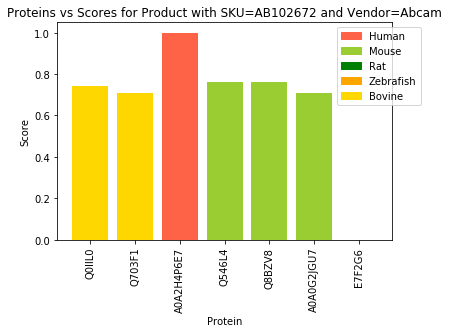

In [12]:
colors = {'Human':'tomato', 'Mouse':'yellowgreen', 'Rat':'green', 'Zebrafish':'orange', 'Bovine':'gold'}

viz_df = cr_df[cr_df['SKU']=='AB102672'].sort_values(['Organism'])
viz_df['Color'] = viz_df['Organism'].apply(lambda x: colors[x])

plt.bar(x = viz_df['Preferred_Name'], height = viz_df['Align_Score_norm'], color = viz_df['Color'])
plt.title('Proteins vs Scores for Product with SKU=AB102672 and Vendor=Abcam')
plt.xlabel('Protein')
plt.ylabel('Score')
plt.xticks(rotation=90)
handles = []
for i,j in colors.items():
    handles.append(mpatches.Patch(label=i, color=j))
plt.legend(handles = handles, bbox_to_anchor=(1.1,1))
plt.show()